# Getting dependencies
opencv - pyton, labelme, tensorflow, tensorflow - gpu, matplotlib
albumentations

In [16]:
#import tensorflow as tf
#print(tf.__version__)

In [17]:
import sys
print(sys.version)

3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:24:38) 
[Clang 12.0.1 ]


# Collecting images using OpenCV

In [18]:
import os
import time
import uuid
import cv2

In [25]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [24]:
# Establishes connection to video camera
cap = cv2.VideoCapture(0)


for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()

    cv2.startWindowThread()

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xff == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)

-1

# Splitting and augmentating data

In [26]:
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.8.0


Limiting GPU memory growth

In [27]:
# Avoiding OOM errors by setting up GPU Memory Consumption Growht

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

In [23]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [37]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [33]:
images = images.map(load_image)
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

Viewing raw images using Matplotlib

In [33]:
image_generator = images.batch(4).as_numpy_iterator()

In [36]:
plot_images = image_generator.next()

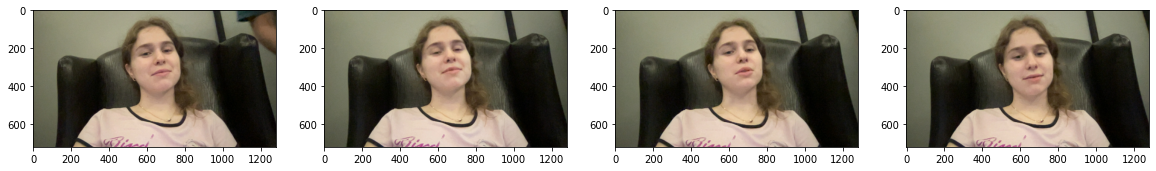

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

Manually splitting data into train test and val

In [41]:
30 * .7 # 24 will be for training

21.0

In [40]:
30*.15 # 5 and 3 for test and val

4.5

In [12]:
import os

In [13]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# Applying Augmentations on Images and Labels using Albumentations

In [14]:
import albumentations as alb
import cv2
import json
import numpy as np

In [15]:
augmentor = alb.Compose([alb.RandomCrop(width=700, height=700),
                           alb.HorizontalFlip(p=0.5),
                           alb.RandomBrightnessContrast(p=0.2),
                           alb.RandomGamma(p=0.2),
                           alb.RGBShift(p=0.2),
                           alb.VerticalFlip(p=0.5)],
                          bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [16]:
img = cv2.imread(os.path.join('data', 'train', 'images', '0aff622a-cfab-11ec-825e-9230ca590061.jpg'))

In [17]:
with open(os.path.join('data', 'train', 'labels', '0aff622a-cfab-11ec-825e-9230ca590061.json'), 'r') as f:
    label = json.load(f)


In [18]:
label['shapes'][0]['points']

[[478.45205479452056, 25.54794520547945],
 [838.7260273972603, 491.30136986301375]]

Loading a test image

In [19]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [20]:
coords

[478.45205479452056, 25.54794520547945, 838.7260273972603, 491.30136986301375]

In [21]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [22]:
coords

[0.3737906678082192,
 0.035483257229832574,
 0.6552547089041096,
 0.6823630136986302]

Applying augmentation

In [23]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [24]:
augmented['bboxes'][0][2:]

(0.7110371819960862, 0.9863600782778865)

In [25]:
augmented['image']

array([[[ 14,  30,   0],
        [ 11,  28,   0],
        [ 12,  30,   0],
        ...,
        [184, 184,  91],
        [184, 184,  91],
        [178, 178,  86]],

       [[ 12,  28,   0],
        [ 13,  31,   0],
        [ 17,  34,   0],
        ...,
        [179, 180,  86],
        [185, 185,  92],
        [179, 179,  87]],

       [[ 13,  30,   0],
        [ 11,  29,   0],
        [ 13,  31,   0],
        ...,
        [180, 179,  85],
        [184, 182,  89],
        [183, 182,  91]],

       ...,

       [[ 30,  66,  36],
        [ 31,  67,  39],
        [ 31,  67,  39],
        ...,
        [ 54,  79,  27],
        [ 54,  78,  28],
        [ 52,  77,  29]],

       [[ 32,  69,  39],
        [ 34,  70,  42],
        [ 31,  67,  39],
        ...,
        [ 60,  82,  30],
        [ 56,  80,  29],
        [ 61,  86,  38]],

       [[ 30,  67,  37],
        [ 30,  65,  37],
        [ 25,  60,  32],
        ...,
        [ 64,  86,  34],
        [ 58,  80,  29],
        [ 51,  75,  27]]

In [26]:
augmented['bboxes']

[(0.1963600782778865,
  0.3209980430528375,
  0.7110371819960862,
  0.9863600782778865)]

In [28]:
from matplotlib import pyplot as plt

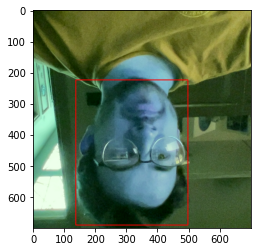

In [29]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [700,700]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [700,700]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# Augmentation pipeline

In [32]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280, 720, 1280, 720]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Expected x_max for bbox [0.2657670454545455, 0.09835858585858585, 1.121590909090909, 2.055429292929293, 'face'] to be in the range [0.0, 1.0], got 1.121590909090909.
image must be numpy array type
image must be numpy array type


# Load images into TF DTS

In [34]:
import tensorflow as tf

In [38]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [39]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [40]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [41]:
train_images.as_numpy_iterator().next()

2022-05-10 15:20:45.960799: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[0.37982026, 0.57589865, 0.66514164],
        [0.3857026 , 0.61315364, 0.69942814],
        [0.40201524, 0.64123094, 0.71574074],
        ...,
        [0.06454236, 0.16258158, 0.15081687],
        [0.05629085, 0.15433006, 0.14256535],
        [0.09607843, 0.16666667, 0.16666667]],

       [[0.34142157, 0.5296569 , 0.6159314 ],
        [0.32058823, 0.5441176 , 0.622549  ],
        [0.40375817, 0.62728757, 0.70179737],
        ...,
        [0.05596403, 0.15400325, 0.14223854],
        [0.01151961, 0.10955882, 0.09779412],
        [0.10032696, 0.16977133, 0.16977133]],

       [[0.36963508, 0.5697713 , 0.6521242 ],
        [0.3393791 , 0.56290853, 0.6413399 ],
        [0.33235297, 0.5558824 , 0.63431376],
        ...,
        [0.0841228 , 0.14294633, 0.15471104],
        [0.09566994, 0.1625817 , 0.17165032],
        [0.06805553, 0.12295748, 0.12295748]],

       ...,

       [[0.29161248, 0.350436  , 0.33082816],
        [0.25465643, 0.3213231 , 0.2977937 ],
        [0.2605666 , 0

In [42]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [44]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [47]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.12  , 0.292 , 0.6387, 0.9614], dtype=float16))

# Combining Label and Image samples

In [48]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2220, 2220, 420, 420, 360, 360)

In [49]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [50]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [51]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [52]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.3577 , 0.433  , 0.906  ],
        [0.4897 , 0.0962 , 0.9556 , 0.687  ],
        [0.319  , 0.3093 , 0.7593 , 0.8906 ],
        [0.3074 , 0.01973, 0.875  , 0.722  ],
        [0.1953 , 0.0427 , 0.6904 , 0.669  ],
        [0.581  , 0.3274 , 1.     , 0.864  ],
        [0.2632 , 0.     , 0.8267 , 0.7295 ],
        [0.02959, 0.03983, 0.525  , 0.666  ]], dtype=float16))

View Images and Annotations

In [53]:
data_samples = train.as_numpy_iterator()

In [54]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


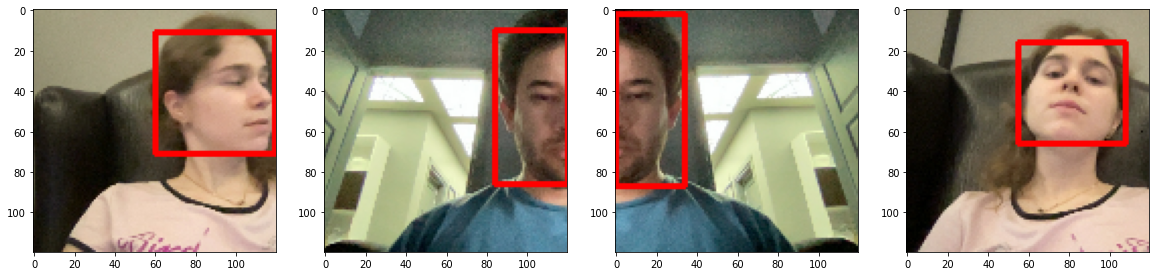

In [55]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Deep Learning Model

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

# VGG16 Model

In [57]:
vgg = VGG16(include_top=False)

58900480/58889256 [==============================] - 12s 0us/step


In [58]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [59]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [60]:
facetracker = build_model()

In [61]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [62]:
X, y = train.as_numpy_iterator().next()

In [63]:
X.shape

(8, 120, 120, 3)

In [64]:
classes, coords = facetracker.predict(X)

2022-05-10 16:09:07.685314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [65]:
classes, coords

(array([[0.5646372 ],
        [0.5865792 ],
        [0.55619204],
        [0.6078324 ],
        [0.5391646 ],
        [0.5814417 ],
        [0.4985321 ],
        [0.52255726]], dtype=float32),
 array([[0.54666066, 0.48940054, 0.66275847, 0.70225173],
        [0.56360847, 0.45564702, 0.66542023, 0.7322988 ],
        [0.5372348 , 0.46575692, 0.6468953 , 0.62195724],
        [0.55941886, 0.5536961 , 0.72061163, 0.6599688 ],
        [0.4907992 , 0.5001638 , 0.7444143 , 0.6925439 ],
        [0.6261239 , 0.49753836, 0.67125034, 0.69738877],
        [0.52288204, 0.45116398, 0.7227373 , 0.71877915],
        [0.5889763 , 0.4703875 , 0.7118274 , 0.68581975]], dtype=float32))

In [66]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [67]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [68]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [69]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [70]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.3336177>

In [71]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5868253>

In [72]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.3336177>

# Training NN

In [73]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [74]:
model = FaceTracker(facetracker)

In [75]:
model.compile(opt, classloss, regressloss)

In [76]:
logdir='logs'

In [77]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [78]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2022-05-10 16:12:22.131446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - ETA: 0s - total_loss: 0.1384 - class_loss: 0.0072 - regress_loss: 0.1348

2022-05-10 16:13:20.269119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - 62s 184ms/step - total_loss: 0.1381 - class_loss: 0.0072 - regress_loss: 0.1345 - val_total_loss: 0.0527 - val_class_loss: 3.7813e-05 - val_regress_loss: 0.0527
Epoch 2/10
278/278 [==============================] - 52s 177ms/step - total_loss: 0.0323 - class_loss: 2.9604e-05 - regress_loss: 0.0323 - val_total_loss: 0.0358 - val_class_loss: 1.6216e-05 - val_regress_loss: 0.0358
Epoch 3/10
278/278 [==============================] - 52s 177ms/step - total_loss: 0.0186 - class_loss: 6.9005e-06 - regress_loss: 0.0186 - val_total_loss: 0.0581 - val_class_loss: 5.8254e-06 - val_regress_loss: 0.0581
Epoch 4/10
278/278 [==============================] - 53s 180ms/step - total_loss: 0.0142 - class_loss: 3.2129e-06 - regress_loss: 0.0142 - val_total_loss: 0.0432 - val_class_loss: 2.7578e-06 - val_regress_loss: 0.0432
Epoch 5/10
278/278 [==============================] - 53s 177ms/step - total_loss: 0.0116 - class_loss: 2.1898e-06 - regress_loss: 0.0116 -

In [78]:
hist.history

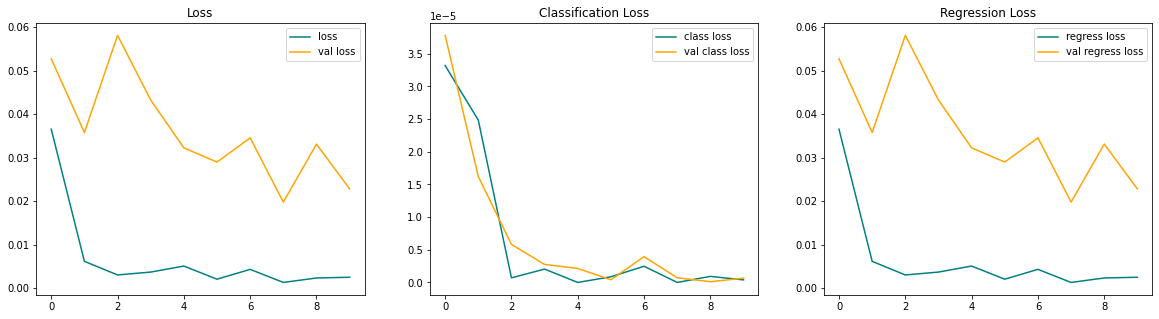

In [79]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Predictions

In [80]:
test_data = test.as_numpy_iterator()

In [81]:
test_sample = test_data.next()

In [82]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


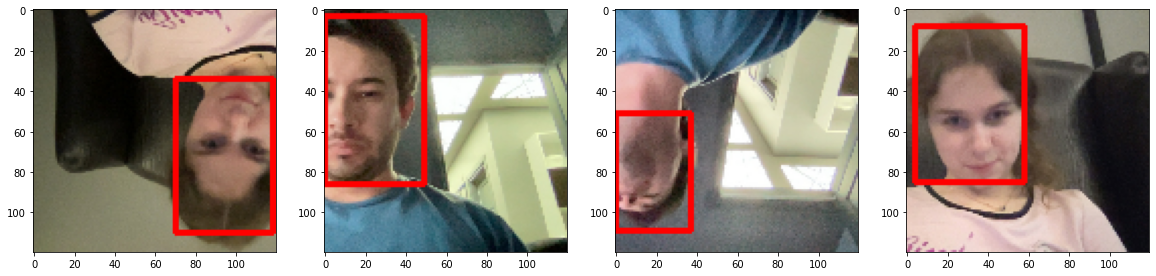

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [1]:
# Saving model
import tensorflow as tf
from tensorflow.keras.models import load_model

In [6]:
#facetracker.save('facetracker.h5')

In [2]:
facetracker = load_model('facetracker.h5')

Metal device set to: Apple M1


2022-05-10 16:34:20.799371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-10 16:34:20.799647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Real Time Detection

In [7]:
import cv2
import numpy as np
import tensorflow as tf
import imutils

In [11]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    #frame = imutils.resize(frame, width=1280)

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)

-1